# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain
from ilqr.utils.visualization import make_video_fn

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

%load_ext autoreload
%autoreload 2

Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']
Choosing the latest nvidia driver: /usr/lib/nvidia-418, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-418']


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 2, use_multiprocessing = True)
print(dynamics.dt)


Finished loading processFinished loading process 16937Finished loading process16936 Finished loading process 
 1693916938Finished loading process
Finished loading process
 
16942 Finished loading process
16947
 16956
Finished loading process Finished loading process 1697316988

0.04
Finished loading process 17000
Finished loading process 17003
Finished loading process 17010


In [7]:
x_goal = np.array([0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(4)
Q[0, 0] = 2.0
Q[1, 1] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
cost2 = FiniteDiffCost(lambda x, u, i: 2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2 + u[0] ** 2,
                      lambda x, i: 100 * (2 * (x[0] ** 2) + 10 * (x[1] ** 2) + x[2] ** 2 + x[3] ** 2),
                      4, 1, use_multiprocessing = True)

Finished loading process Finished loading process17049Finished loading process 
17052 
17048
Finished loading process 17061
Finished loading process 17082Finished loading process
 17087
Finished loading processFinished loading process  1709217103

Finished loading process Finished loading process17116
 17123
Finished loading process 17130
Finished loading process 17143


In [9]:
N = 100
x0 = np.array([0.0, np.pi - 1, 0.0, 0.0])
us_init = np.array([[-4.76751939e-01],
 [ 3.34490970e-01],
 [-3.99608551e-01],
 [ 8.41882163e-01],
 [-8.93302461e-01],
 [-3.57273055e-01],
 [-3.32158856e-01],
 [-4.82030121e-01],
 [-6.84388675e-01],
 [-4.26475287e-01],
 [-4.90913171e-01],
 [ 1.14754770e-01],
 [ 3.90275383e-01],
 [-4.36421243e-01],
 [ 5.57806778e-01],
 [ 7.83813923e-01],
 [-3.27778717e-01],
 [ 8.00582346e-01],
 [-8.49640982e-01],
 [-5.69222128e-01],
 [ 2.58447724e-01],
 [ 6.02857039e-01],
 [-6.11855326e-01],
 [ 7.00853348e-01],
 [-9.31090157e-01],
 [ 4.97665652e-01],
 [ 2.45721323e-01],
 [-1.92025996e-01],
 [ 2.72219728e-02],
 [ 7.95701514e-01],
 [-8.92320606e-01],
 [ 3.22802941e-02],
 [ 2.69562194e-01],
 [-1.46125346e-01],
 [-3.15934186e-02],
 [ 6.61809200e-01],
 [ 4.76622656e-01],
 [-9.78007260e-01],
 [ 5.73481914e-01],
 [-1.28208542e-02],
 [ 1.48147746e-01],
 [ 1.39421731e-04],
 [ 1.08812740e-01],
 [ 6.16007441e-01],
 [ 2.66982969e-01],
 [-2.09250070e-02],
 [ 6.04343953e-02],
 [ 4.14836049e-01],
 [-7.01346473e-01],
 [ 2.94563133e-01],
 [-3.07180590e-01],
 [ 6.53429823e-01],
 [ 3.87696411e-01],
 [-1.60361255e-01],
 [-7.91982930e-01],
 [ 3.04331662e-01],
 [-3.33057338e-01],
 [-1.45487867e-01],
 [-4.48293362e-01],
 [-4.56753222e-01],
 [-5.63113978e-02],
 [ 9.17106858e-01],
 [-7.79117478e-01],
 [-7.74944928e-01],
 [ 1.26081663e-01],
 [ 8.11397037e-02],
 [-6.58667412e-01],
 [ 9.01877119e-01],
 [-7.59017615e-01],
 [-6.54909707e-01],
 [-7.19152458e-01],
 [-8.23250291e-01],
 [-1.96576912e-01],
 [ 3.31076346e-01],
 [-9.59322994e-01],
 [ 6.61615691e-01],
 [-4.48940253e-01],
 [-4.10547311e-01],
 [-8.26340358e-01],
 [ 7.48939731e-01],
 [-8.83894866e-01],
 [ 4.12684469e-01],
 [-4.61578622e-01],
 [-8.29689676e-01],
 [-9.02561735e-01],
 [-2.44970624e-01],
 [ 2.86652487e-01],
 [-8.59512109e-01],
 [-5.89043961e-01],
 [ 6.21286175e-01],
 [-4.02464523e-01],
 [-7.80221770e-01],
 [-7.58513349e-01],
 [ 5.35469863e-01],
 [ 7.43535637e-01],
 [ 9.40814704e-01],
 [-9.31071558e-01],
 [-4.20465454e-01],
 [-1.28056017e-01],
 [-2.09487816e-01]])
#us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost2, N)

In [10]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 20999.165008172444 [-1.96043877  1.69542002 -0.53943987 -7.17417439]
iteration 1 accepted 18316.701549815847 [-1.98984531  2.34786135  0.60365085 -0.0562709 ]
iteration 2 accepted 15416.206245900445 [-2.1703262   1.272489   -1.00191462 -3.03666907]
iteration 3 accepted 14572.248590658497 [-1.61971752  1.17480898 -1.05051864 -2.73087493]
iteration 4 accepted 13907.746671210969 [-0.7930531   1.09029587  0.78850722 -1.82670815]
iteration 5 accepted 13675.88482060394 [-0.9774937   0.7185033   1.07551589 -3.87433017]
iteration 6 accepted 13135.317669995891 [-1.33466176  1.29772564 -1.70227148 -1.48285422]
iteration 7 accepted 12116.113497700719 [-0.93103919  1.16745253 -1.48939862 -1.41977204]
iteration 8 accepted 11778.339960969526 [-0.81295818  1.236406   -1.61022788 -0.63245119]
iteration 9 accepted 11300.407550803182 [-0.37254105  1.17472321 -1.20343279 -0.64472065]
iteration 10 accepted 11284.330599551435 [-0.46298876  1.04774587 -1.81025433 -0.4335937 ]
iteration 

iteration 92 accepted 7809.245414466608 [-0.1365281  -0.04944858  0.33115237  0.21394024]
iteration 93 accepted 7787.101559038114 [-0.10116204 -0.04646127  0.32074861  0.1962365 ]
iteration 94 accepted 7746.997186416735 [-0.28393738 -0.05352038  0.32347916  0.19020945]
iteration 95 accepted 7722.933360356909 [-0.34430762 -0.05548335  0.32516723  0.18242871]
iteration 96 accepted 7721.398631424766 [-0.49379351 -0.06223858  0.34229232  0.17804556]
iteration 97 accepted 7701.637820240827 [-0.21612328 -0.04974491  0.31216527  0.17412808]
iteration 98 accepted 7671.762578854523 [-0.32313044 -0.0560469   0.33265582  0.17662493]
iteration 99 accepted 7648.3786331637575 [-0.38453126 -0.0580514   0.33557247  0.1677945 ]
iteration 100 accepted 7640.220501559665 [-0.56323727 -0.06938816  0.37806703  0.17557968]
iteration 101 accepted 7567.401362453177 [-0.12391787 -0.04306742  0.27296184  0.14403714]
iteration 102 accepted 7537.833456778101 [-0.23260642 -0.04920115  0.29386885  0.1498495 ]
iterat

iteration 184 accepted 5309.792517469162 [-0.08870492 -0.02076423  0.10446251  0.04918613]
iteration 185 accepted 5285.995712933472 [-0.0803952  -0.01921759  0.09634867  0.04533821]
iteration 186 accepted 5266.554293035396 [-0.05379185 -0.01443411  0.07068671  0.03394814]
iteration 187 accepted 5248.990741602232 [-0.08586544 -0.01979156  0.09965938  0.047089  ]
iteration 188 accepted 5240.587975228787 [-0.12648552 -0.02687601  0.13698276  0.06475851]
iteration 189 accepted 5208.908516233433 [ 0.05128649  0.0042524  -0.04152203 -0.00020572]
iteration 190 accepted 5200.086044576962 [ 0.04893817  0.00249703 -0.02492066 -0.00472762]
iteration 191 accepted 5147.904308518693 [ 0.06239515  0.00524049 -0.03758171 -0.01293546]
iteration 192 accepted 5115.108419104435 [ 0.03813535  0.00207639 -0.01785439 -0.00637711]
iteration 193 accepted 5092.813660630288 [ 0.03369087  0.00149311 -0.0142809  -0.00501011]
iteration 194 accepted 5092.564298418243 [ 0.01911111 -0.00056152 -0.00198424 -0.00023621]

iteration 274 accepted 3200.9830949834013 [ 0.01595896  0.00278267 -0.0153358  -0.00691136]
iteration 275 accepted 3174.2777036970315 [-0.01160222 -0.00341933  0.01609457  0.0075365 ]
iteration 276 accepted 3157.3501384448286 [-0.02548119 -0.00652923  0.03182222  0.01484416]
iteration 277 accepted 3112.856610901192 [-0.00880625 -0.00274974  0.01263858  0.00608886]
iteration 278 accepted 3099.5260584739694 [-0.00211188 -0.00122661  0.00497296  0.0025294 ]
iteration 279 accepted 3070.147132295282 [-0.01303488 -0.00367659  0.01743695  0.00823487]
iteration 280 accepted 3061.1363698252517 [-0.02669047 -0.00675369  0.03299747  0.01543214]
iteration 281 accepted 3014.4379004910966 [ 1.80987623e-03 -2.69394713e-04  4.14247109e-05  4.56548273e-04]
iteration 282 accepted 2958.491719205251 [ 0.00693408  0.00088135 -0.00557958 -0.00236562]
iteration 283 accepted 2924.595227700815 [-0.00057053 -0.00080642  0.00301669  0.00154848]
iteration 284 accepted 2900.354110969609 [ 0.0012562  -0.00034776  0

In [11]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

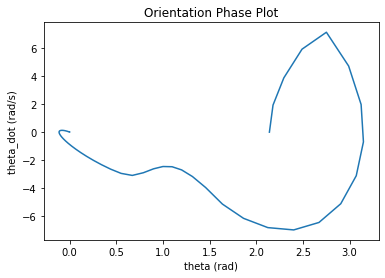

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

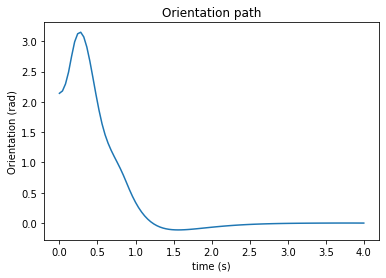

In [42]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

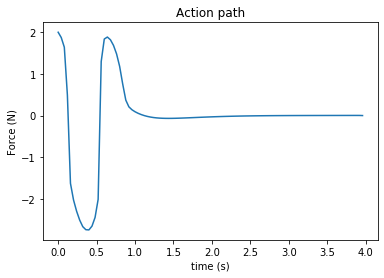

In [43]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

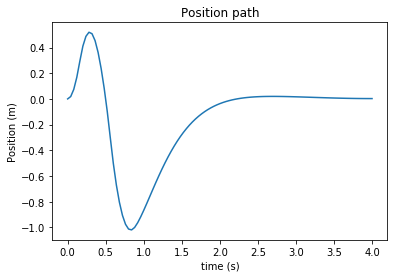

In [44]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

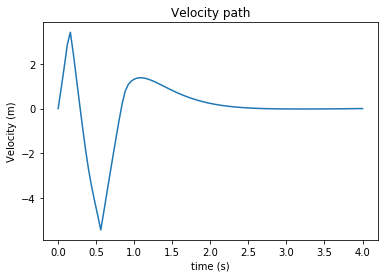

In [45]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

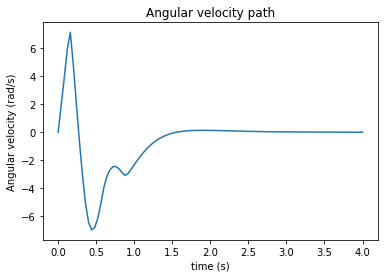

In [46]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

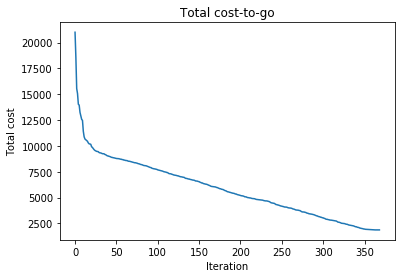

In [47]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [48]:
dynamics.set_state(x0)
print(dynamics.get_state())
video = []
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    video.append(dynamics.sim.render(512, 512))
make_video_fn(video)()

Creating window glfw
[0.         2.14159265 0.         0.        ]
0 [1.9980842]
[0.01835764 2.18039918 0.92008372 1.93082176] [0.01835764 2.18039918 0.92008372 1.93082176]

1 [1.87088408]
[0.07388471 2.29608299 1.86542366 3.86896442] [0.07388471 2.29608299 1.86542366 3.86896442]

2 [1.63905907]
[0.16803653 2.4911347  2.85559211 5.91490111] [0.16803653 2.4911347  2.85559211 5.91490111]

3 [0.49041769]
[0.29357379 2.75228147 3.42053472 7.12149979] [0.29357379 2.75228147 3.42053472 7.12149979]

4 [-1.62831889]
[0.4111702  2.99061806 2.43835268 4.71346845] [0.4111702  2.99061806 2.43835268 4.71346845]

5 [-2.02777121]
[0.48693342 3.12431104 1.34768911 1.97065637] [0.48693342 3.12431104 1.34768911 1.97065637]

6 [-2.29710191]
[ 0.518831    3.14919475  0.25123576 -0.69180678] [ 0.518831    3.14919475  0.25123576 -0.69180678]

7 [-2.50944193]
[ 0.50728711  3.07213291 -0.82184481 -3.10654112] [ 0.50728711  3.07213291 -0.82184481 -3.10654112]

8 [-2.66651761]
[ 0.45378273  2.90613261 -1.839292

70 [-0.00327901]
[ 0.01862029 -0.00834497 -0.01117078  0.02664496] [ 0.01862029 -0.00834497 -0.01117078  0.02664496]

71 [-0.00279065]
[ 0.01813304 -0.00733472 -0.01321521  0.02410912] [ 0.01813304 -0.00733472 -0.01321521  0.02410912]

72 [-0.00235134]
[ 0.017571   -0.00642107 -0.01490884  0.02179322] [ 0.017571   -0.00642107 -0.01490884  0.02179322]

73 [-0.00195655]
[ 0.01694744 -0.00559547 -0.01628868  0.0196853 ] [ 0.01694744 -0.00559547 -0.01628868  0.0196853 ]

74 [-0.001602]
[ 0.01627427 -0.0048499  -0.01738801  0.01777308] [ 0.01627427 -0.0048499  -0.01738801  0.01777308]

75 [-0.00128367]
[ 0.0155621  -0.00417681 -0.01823665  0.01604407] [ 0.0155621  -0.00417681 -0.01823665  0.01604407]

76 [-0.00099779]
[ 0.01482044 -0.00356915 -0.01886116  0.01448568] [ 0.01482044 -0.00356915 -0.01886116  0.01448568]

77 [-0.00074081]
[ 0.01405778 -0.00302039 -0.01928506  0.01308522] [ 0.01405778 -0.00302039 -0.01928506  0.01308522]

78 [-0.00050945]
[ 0.01328174 -0.00252448 -0.01952905  0.0